Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
%matplotlib inline

Read Data

In [2]:
file = pd.ExcelFile("../../data/final/Handball_09.03.2023_fertig.xlsx")

file.sheet_names

df = file.parse('3. League')

# drop last col comments & favorite corner & empy rows at end
df = df.iloc[:, :-2]
df.columns


Index(['Home team', 'Guest team', 'Matchday', 'Player 3rd league',
       'Shooter team', 'club region', 'Game Minute',
       'Difference between\nfinal whistle and kickoff \n(in seconds)',
       'Home Goal', 'Guest Goal',
       'Goalkeeper position\n(0 = on the line;\n 1 = in front of the line)',
       'Toss successful?\n(0 = no; 1 = yes;\n 2 = yes, afterthrow',
       'Left/right \nhanded?\n(1 = right; 2 = left)', 'Throw direction',
       'Pressure situation?\n(0 = no; \n1= Goalkeeper change;\n2 = last 7 meter held; 3 = goal difference < 4 + from 50. minute; 4 = 1+2; 5 = 1+3; 6 = 2+3; 7 = 1+2+3; 8 = last 7 meter successful in follow-up throw\n',
       'Number of seven meters\n(of the player)',
       'Throw quadrant last 7 meter',
       'last 7 meter successful?\n(0 = no; 1 = yes; \n2 = yes, in the afterthrow'],
      dtype='object')

Cleanup & Renaming

In [3]:
df.replace('unklar', np.nan,inplace=True)
df.replace('unklar ', np.nan,inplace=True)
df.replace('fehlend', np.nan,inplace=True)
df.replace('-', np.nan,inplace=True)
df.replace(-99, np.nan,inplace=True)
df.replace('-99', np.nan,inplace=True)
df.replace('?', np.nan,inplace=True)
df.replace('?!', np.nan,inplace=True)
#df.dropna(inplace=True)
df.columns = [ 'homeTeam','opponentTeam','day','name','team','region','playTime',
              'whistleThrowTime','homeGoals','opponentGoals',
              'goalKeeperPosition',
              'throwSuccess','LRHandy','throwDirection',
              'pressureSituation','noOfThrowsFromPlayer',
              'throwQuadrantLastThrow','lastThrowSuccess']
df = df.astype({'homeTeam':'string', 'opponentTeam':'string','day':'float16','name':'string','team':'string','region':'string','playTime':'float16',
              'whistleThrowTime':'float16','homeGoals':'float16','opponentGoals':'float16','goalKeeperPosition':'float16',
              'throwSuccess':'float16','LRHandy':'float16','throwDirection':'float16','pressureSituation':'float16','noOfThrowsFromPlayer':'float16',
              'throwQuadrantLastThrow':'float16','lastThrowSuccess':'float16', })

df['homeTeam']=df['homeTeam'].str.rstrip()
df['opponentTeam']=df['opponentTeam'].str.rstrip()
df['team']=df['team'].str.rstrip()
df['oTeam'] = [ot if str(ht) == str(t) else ht for ht,ot,t in zip(df['homeTeam'],df['opponentTeam'],df['team'])]
df['oTeam'] = df['oTeam'].astype('string')
df

,homeTeam,opponentTeam,day,name,team,region,playTime,whistleThrowTime,homeGoals,opponentGoals,goalKeeperPosition,throwSuccess,LRHandy,throwDirection,pressureSituation,noOfThrowsFromPlayer,throwQuadrantLastThrow,lastThrowSuccess,oTeam
0,TV Emsdetten,ASV Hamm-Westfalen II,1.0,<NA>,<NA>,west,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TV Emsdetten
1,HLZ Ahlener SG,TV Emsdetten,2.0,<NA>,<NA>,west,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HLZ Ahlener SG
2,TV Emsdetten,VfL Gladbeck,3.0,HRS,TV Emsdetten,west,2.0,23.0,0.0,0.0,1.0,1.0,1.0,8.0,0.0,1.0,NaN,1.0,VfL Gladbeck
3,TV Emsdetten,VfL Gladbeck,3.0,HRS,TV Emsdetten,west,7.0,16.0,5.0,1.0,1.0,1.0,1.0,3.0,0.0,2.0,8.0,1.0,VfL Gladbeck
4,TV Emsdetten,VfL Gladbeck,3.0,HRS,TV Emsdetten,west,31.0,28.0,19.0,9.0,1.0,1.0,1.0,7.0,0.0,3.0,3.0,1.0,VfL Gladbeck
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,Stralsunder HV,DHK Flensborg,19.0,SKL,Stralsunder HV,north,6.0,23.0,3.0,2.0,1.0,1.0,1.0,4.0,0.0,1.0,NaN,NaN,DHK Flensborg
1015,Stralsunder HV,DHK Flensborg,19.0,SKL,Stralsunder HV,north,29.0,20.0,20.0,14.0,1.0,1.0,1.0,3.0,0.0,2.0,4.0,1.0,DHK Flensborg
1016,Stralsunder HV,DHK Flensborg,19.0,SKL,Stralsunder HV,north,49.0,36.0,28.0,22.0,1.0,0.0,1.0,3.0,0.0,3.0,3.0,1.0,DHK Flensborg
1017,Stralsunder HV,DHK Flensborg,19.0,SKL,Stralsunder HV,north,29.0,20.0,20.0,14.0,1.0,1.0,1.0,3.0,0.0,2.0,4.0,1.0,DHK Flensborg


Data Prep

In [4]:
# Dropped less data : 'homeTeam','opponentTeam', 'throwQuadrantLastThrow','lastThrowSuccess', 

feat = df.loc[:,('day','name','team','region','playTime',
              'whistleThrowTime','homeGoals','opponentGoals',
              'goalKeeperPosition',
              'throwSuccess','LRHandy','throwDirection',
              'pressureSituation','noOfThrowsFromPlayer','oTeam'
              )].copy()

feat

,day,name,team,region,playTime,whistleThrowTime,homeGoals,opponentGoals,goalKeeperPosition,throwSuccess,LRHandy,throwDirection,pressureSituation,noOfThrowsFromPlayer,oTeam
0,1.0,<NA>,<NA>,west,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TV Emsdetten
1,2.0,<NA>,<NA>,west,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HLZ Ahlener SG
2,3.0,HRS,TV Emsdetten,west,2.0,23.0,0.0,0.0,1.0,1.0,1.0,8.0,0.0,1.0,VfL Gladbeck
3,3.0,HRS,TV Emsdetten,west,7.0,16.0,5.0,1.0,1.0,1.0,1.0,3.0,0.0,2.0,VfL Gladbeck
4,3.0,HRS,TV Emsdetten,west,31.0,28.0,19.0,9.0,1.0,1.0,1.0,7.0,0.0,3.0,VfL Gladbeck
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,19.0,SKL,Stralsunder HV,north,6.0,23.0,3.0,2.0,1.0,1.0,1.0,4.0,0.0,1.0,DHK Flensborg
1015,19.0,SKL,Stralsunder HV,north,29.0,20.0,20.0,14.0,1.0,1.0,1.0,3.0,0.0,2.0,DHK Flensborg
1016,19.0,SKL,Stralsunder HV,north,49.0,36.0,28.0,22.0,1.0,0.0,1.0,3.0,0.0,3.0,DHK Flensborg
1017,19.0,SKL,Stralsunder HV,north,29.0,20.0,20.0,14.0,1.0,1.0,1.0,3.0,0.0,2.0,DHK Flensborg


WhistleTime

Median:  [30.0]
Mean:  [32.9]
Minimum:  [11.0]
Maximum:  [55.0]
Q1:  [23.0]
Q3:  [36.0]
Fliers:  [[  3.  57.  58.  58.  58.  59.  60.  60.  61.  61.  61.  63.  65.  66.
   66.  66.  66.  67.  67.  68.  70.  72.  76.  80.  81.  83.  84.  93.
   93.  96.  99. 112. 114. 117. 128. 131. 143. 177.]]


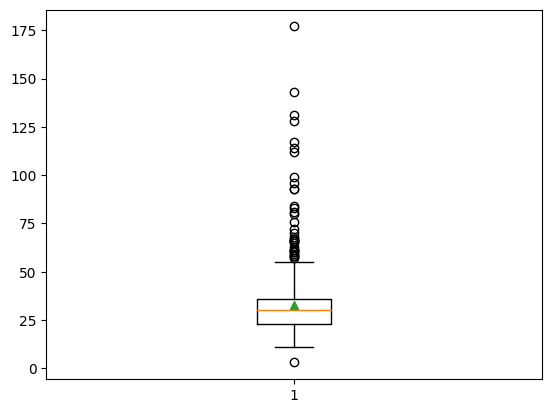

In [5]:
dfwt = feat.loc[:,('whistleThrowTime')].copy()
dfwt.dropna(inplace=True)
bp = plt.boxplot(dfwt, showmeans=True)

medians = [round(item.get_ydata()[0], 1) for item in bp['medians']]
print('Median: ',medians)
means = [round(item.get_ydata()[0], 1) for item in bp['means']]
print('Mean: ',means)
minimums = [round(item.get_ydata()[0], 1) for item in bp['caps']][::2]
print('Minimum: ',minimums)
maximums = [round(item.get_ydata()[0], 1) for item in bp['caps']][1::2]
print('Maximum: ',maximums)
q1 = [round(min(item.get_ydata()), 1) for item in bp['boxes']]
print('Q1: ',q1)
q3 = [round(max(item.get_ydata()), 1) for item in bp['boxes']]
print('Q3: ',q3)
fliers = [item.get_ydata() for item in bp['fliers']]
print('Fliers: ',np.sort(fliers))

Update missing Whistle Time Column

In [6]:
#feat['whistleThrowTime'].replace( np.nan,30,inplace=True)
#feat['whistleThrowTime']

## Replaye Nan for whistleThrowTime with 0 and add it relavancy column ad binary
feat['whistleThrowTime'].replace( np.nan,0,inplace=True)
feat['whistleThrowTimeRelevant'] = [0 if time == 0 else 1 for time in feat['whistleThrowTime']]
feat

,day,name,team,region,playTime,whistleThrowTime,homeGoals,opponentGoals,goalKeeperPosition,throwSuccess,LRHandy,throwDirection,pressureSituation,noOfThrowsFromPlayer,oTeam,whistleThrowTimeRelevant
0,1.0,<NA>,<NA>,west,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TV Emsdetten,0
1,2.0,<NA>,<NA>,west,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HLZ Ahlener SG,0
2,3.0,HRS,TV Emsdetten,west,2.0,23.0,0.0,0.0,1.0,1.0,1.0,8.0,0.0,1.0,VfL Gladbeck,1
3,3.0,HRS,TV Emsdetten,west,7.0,16.0,5.0,1.0,1.0,1.0,1.0,3.0,0.0,2.0,VfL Gladbeck,1
4,3.0,HRS,TV Emsdetten,west,31.0,28.0,19.0,9.0,1.0,1.0,1.0,7.0,0.0,3.0,VfL Gladbeck,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,19.0,SKL,Stralsunder HV,north,6.0,23.0,3.0,2.0,1.0,1.0,1.0,4.0,0.0,1.0,DHK Flensborg,1
1015,19.0,SKL,Stralsunder HV,north,29.0,20.0,20.0,14.0,1.0,1.0,1.0,3.0,0.0,2.0,DHK Flensborg,1
1016,19.0,SKL,Stralsunder HV,north,49.0,36.0,28.0,22.0,1.0,0.0,1.0,3.0,0.0,3.0,DHK Flensborg,1
1017,19.0,SKL,Stralsunder HV,north,29.0,20.0,20.0,14.0,1.0,1.0,1.0,3.0,0.0,2.0,DHK Flensborg,1


Remove Null

In [7]:
feat.dropna(inplace=True)
feat.info()
feat

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 2 to 1018
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   day                       629 non-null    float16
 1   name                      629 non-null    string 
 2   team                      629 non-null    string 
 3   region                    629 non-null    string 
 4   playTime                  629 non-null    float16
 5   whistleThrowTime          629 non-null    float16
 6   homeGoals                 629 non-null    float16
 7   opponentGoals             629 non-null    float16
 8   goalKeeperPosition        629 non-null    float16
 9   throwSuccess              629 non-null    float16
 10  LRHandy                   629 non-null    float16
 11  throwDirection            629 non-null    float16
 12  pressureSituation         629 non-null    float16
 13  noOfThrowsFromPlayer      629 non-null    float16
 14  oTeam    

,day,name,team,region,playTime,whistleThrowTime,homeGoals,opponentGoals,goalKeeperPosition,throwSuccess,LRHandy,throwDirection,pressureSituation,noOfThrowsFromPlayer,oTeam,whistleThrowTimeRelevant
2,3.0,HRS,TV Emsdetten,west,2.0,23.0,0.0,0.0,1.0,1.0,1.0,8.0,0.0,1.0,VfL Gladbeck,1
3,3.0,HRS,TV Emsdetten,west,7.0,16.0,5.0,1.0,1.0,1.0,1.0,3.0,0.0,2.0,VfL Gladbeck,1
4,3.0,HRS,TV Emsdetten,west,31.0,28.0,19.0,9.0,1.0,1.0,1.0,7.0,0.0,3.0,VfL Gladbeck,1
5,3.0,HRS,TV Emsdetten,west,51.0,22.0,31.0,20.0,1.0,1.0,1.0,1.0,0.0,4.0,VfL Gladbeck,1
6,3.0,HRS,TV Emsdetten,west,54.0,31.0,35.0,22.0,1.0,1.0,1.0,3.0,0.0,5.0,VfL Gladbeck,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,19.0,SKL,Stralsunder HV,north,6.0,23.0,3.0,2.0,1.0,1.0,1.0,4.0,0.0,1.0,DHK Flensborg,1
1015,19.0,SKL,Stralsunder HV,north,29.0,20.0,20.0,14.0,1.0,1.0,1.0,3.0,0.0,2.0,DHK Flensborg,1
1016,19.0,SKL,Stralsunder HV,north,49.0,36.0,28.0,22.0,1.0,0.0,1.0,3.0,0.0,3.0,DHK Flensborg,1
1017,19.0,SKL,Stralsunder HV,north,29.0,20.0,20.0,14.0,1.0,1.0,1.0,3.0,0.0,2.0,DHK Flensborg,1


In [8]:
# Excat info may be learned : 'day','team','region','playTime','oTeam',
# Future: 'throwSuccess',
# not much significant: 'LRHandy','noOfThrowsFromPlayer'
# included in pressure situation : 'homeGoals','opponentGoals'

feat = feat.loc[:,('name','whistleThrowTime','whistleThrowTimeRelevant','goalKeeperPosition','pressureSituation','throwDirection')]



feat

,name,whistleThrowTime,whistleThrowTimeRelevant,goalKeeperPosition,pressureSituation,throwDirection
2,HRS,23.0,1,1.0,0.0,8.0
3,HRS,16.0,1,1.0,0.0,3.0
4,HRS,28.0,1,1.0,0.0,7.0
5,HRS,22.0,1,1.0,0.0,1.0
6,HRS,31.0,1,1.0,0.0,3.0
...,...,...,...,...,...,...
1014,SKL,23.0,1,1.0,0.0,4.0
1015,SKL,20.0,1,1.0,0.0,3.0
1016,SKL,36.0,1,1.0,0.0,3.0
1017,SKL,20.0,1,1.0,0.0,3.0


Encoding Data

In [9]:
# encode the Categorical Variable
from sklearn.preprocessing import LabelEncoder 
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [10]:
#feat_cols = feat.select_dtypes(include=["string"]).columns
#float_cols = feat.select_dtypes(include=["float16"]).columns
#feat = MultiColumnLabelEncoder(columns = feat_cols).fit_transform(feat)
#feat = feat.astype('int32')
#feat.info()
#pd.set_option("display.max_rows", None, "display.max_columns", None)
#feat

In [11]:
feat = pd.get_dummies(feat, columns=['name','pressureSituation'], drop_first=False)
feat.head()

,whistleThrowTime,whistleThrowTimeRelevant,goalKeeperPosition,throwDirection,name_BCT,name_BERD,name_BHD,name_BRB,name_BRN,name_CDS,...,name_zGT,pressureSituation_0.0,pressureSituation_1.0,pressureSituation_2.0,pressureSituation_3.0,pressureSituation_4.0,pressureSituation_5.0,pressureSituation_6.0,pressureSituation_7.0,pressureSituation_8.0
2,23.0,1,1.0,8.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,16.0,1,1.0,3.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,28.0,1,1.0,7.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,22.0,1,1.0,1.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6,31.0,1,1.0,3.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Input & Output Data

In [12]:

X = feat.loc[:, feat.columns != 'throwDirection']
y = pd.get_dummies(feat['throwDirection'], drop_first=False)

y

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
2,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0
5,1,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1014,0,0,0,1,0,0,0,0,0
1015,0,0,1,0,0,0,0,0,0
1016,0,0,1,0,0,0,0,0,0
1017,0,0,1,0,0,0,0,0,0


Dataset

In [13]:
class TabularDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

Model

In [14]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.bn2 = nn.BatchNorm1d(num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = torch.softmax(out, dim=1)
        return out

Train

In [15]:
def train(model, train_loader, epoch ,criterion,optimizer):
   
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item()

    print(f"Epoch {epoch+1}, Trainloss: {running_loss}")
    print(f"Train Accuracy: {(100 * correct / total):.2f}%")
    return running_loss, (100 * correct / total)




Test

In [16]:
def test(model, test_loader,criterion):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels.argmax(dim=1)).sum().item()

        print(f"Test loss: {running_loss}")
        print(f"Test Accuracy: {(100 * correct / total):.2f}%")
        return running_loss, (100 * correct / total)

Params

In [17]:
num_epochs = 100
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()


Train Test Split

Training Features Shape: (524, 49)
Training Labels Shape: (524, 9)
Testing Features Shape: (105, 49)
Testing Labels Shape: (105, 9)
Epoch 1, Trainloss: 72.46782660484314
Train Accuracy: 10.88%
Test loss: 15.444040536880493
Test Accuracy: 8.57%
Epoch 2, Trainloss: 72.10958194732666
Train Accuracy: 16.22%
Test loss: 15.415942430496216
Test Accuracy: 12.38%
Epoch 3, Trainloss: 71.80997943878174
Train Accuracy: 18.32%
Test loss: 15.385898113250732
Test Accuracy: 14.29%
Epoch 4, Trainloss: 71.59684801101685
Train Accuracy: 19.66%
Test loss: 15.362656593322754
Test Accuracy: 14.29%
Epoch 5, Trainloss: 71.40954923629761
Train Accuracy: 21.37%
Test loss: 15.337377786636353
Test Accuracy: 15.24%
Epoch 6, Trainloss: 71.27074956893921
Train Accuracy: 22.90%
Test loss: 15.315853357315063
Test Accuracy: 18.10%
Epoch 7, Trainloss: 71.09837770462036
Train Accuracy: 23.47%
Test loss: 15.291064977645874
Test Accuracy: 18.10%
Epoch 8, Trainloss: 70.95217847824097
Train Accuracy: 23.85%
Test loss: 15.260

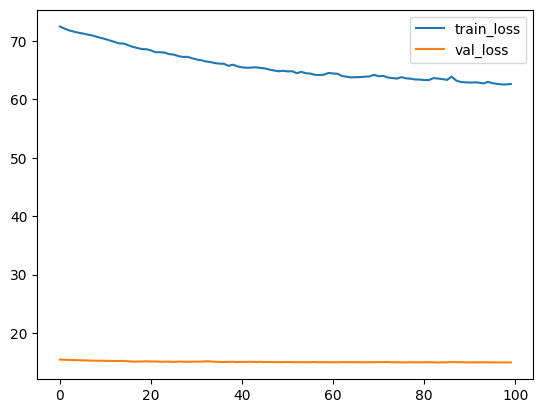

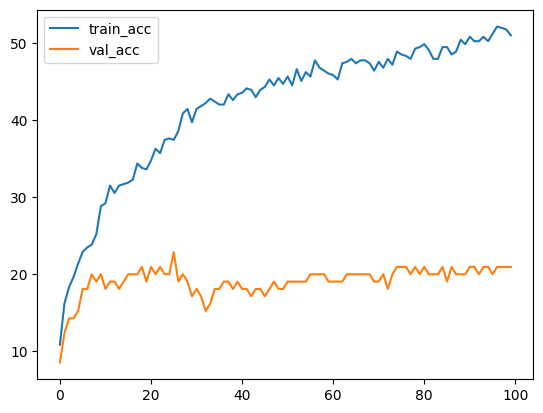

105 22

Accuracy: 20.95

Training Features Shape: (524, 49)
Training Labels Shape: (524, 9)
Testing Features Shape: (105, 49)
Testing Labels Shape: (105, 9)
Epoch 1, Trainloss: 72.6351215839386
Train Accuracy: 12.79%
Test loss: 15.403637886047363
Test Accuracy: 11.43%
Epoch 2, Trainloss: 72.40526986122131
Train Accuracy: 15.08%
Test loss: 15.393873691558838
Test Accuracy: 11.43%
Epoch 3, Trainloss: 72.08979034423828
Train Accuracy: 20.61%
Test loss: 15.370578527450562
Test Accuracy: 13.33%
Epoch 4, Trainloss: 71.74758911132812
Train Accuracy: 20.99%
Test loss: 15.359806537628174
Test Accuracy: 16.19%
Epoch 5, Trainloss: 71.52871966362
Train Accuracy: 21.95%
Test loss: 15.360840797424316
Test Accuracy: 14.29%
Epoch 6, Trainloss: 71.29306888580322
Train Accuracy: 23.66%
Test loss: 15.358368635177612
Test Accuracy: 15.24%
Epoch 7, Trainloss: 71.08418989181519
Train Accuracy: 24.81%
Test loss: 15.357011795043945
Test Accuracy: 17.14%
Epoch 8, Trainloss: 70.84200835227966
Train Accuracy: 26

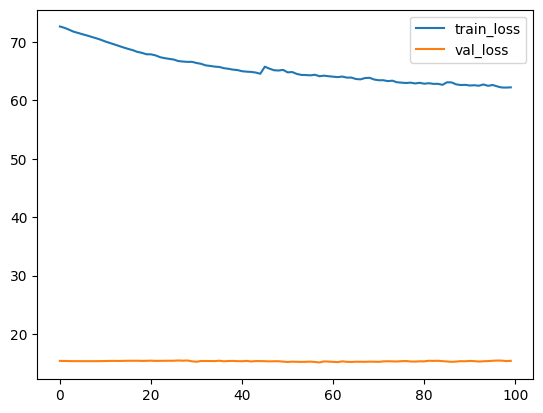

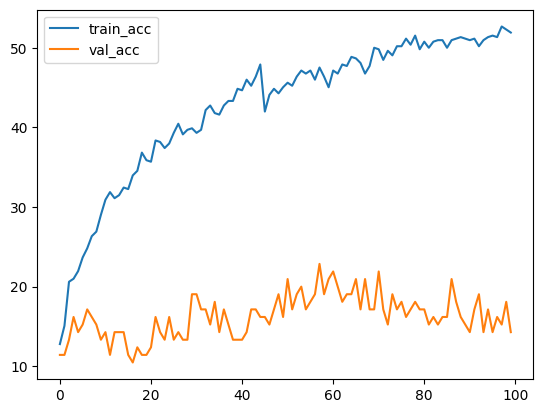

105 15

Accuracy: 14.29

Training Features Shape: (524, 49)
Training Labels Shape: (524, 9)
Testing Features Shape: (105, 49)
Testing Labels Shape: (105, 9)
Epoch 1, Trainloss: 72.88569283485413
Train Accuracy: 6.87%
Test loss: 15.472932577133179
Test Accuracy: 9.52%
Epoch 2, Trainloss: 72.66932702064514
Train Accuracy: 11.83%
Test loss: 15.458507537841797
Test Accuracy: 10.48%
Epoch 3, Trainloss: 72.44854378700256
Train Accuracy: 16.03%
Test loss: 15.43378472328186
Test Accuracy: 15.24%
Epoch 4, Trainloss: 72.2630627155304
Train Accuracy: 18.70%
Test loss: 15.45002818107605
Test Accuracy: 12.38%
Epoch 5, Trainloss: 72.02740669250488
Train Accuracy: 19.27%
Test loss: 15.433321475982666
Test Accuracy: 13.33%
Epoch 6, Trainloss: 71.7694308757782
Train Accuracy: 22.71%
Test loss: 15.437104940414429
Test Accuracy: 14.29%
Epoch 7, Trainloss: 71.55771327018738
Train Accuracy: 22.90%
Test loss: 15.426968336105347
Test Accuracy: 15.24%
Epoch 8, Trainloss: 71.24886989593506
Train Accuracy: 25.3

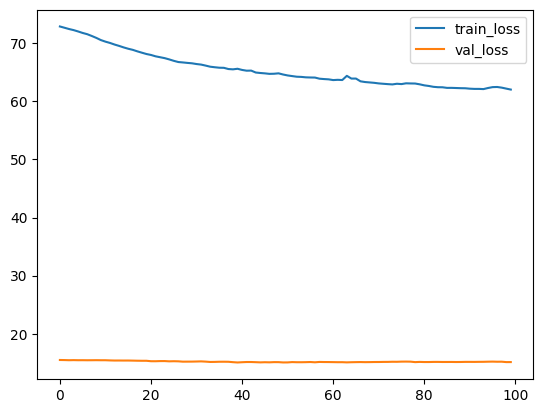

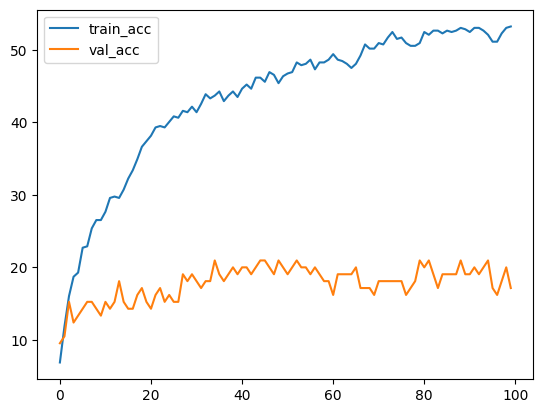

105 18

Accuracy: 17.14

Training Features Shape: (524, 49)
Training Labels Shape: (524, 9)
Testing Features Shape: (105, 49)
Testing Labels Shape: (105, 9)
Epoch 1, Trainloss: 72.30333304405212
Train Accuracy: 15.08%
Test loss: 15.247122287750244
Test Accuracy: 22.86%
Epoch 2, Trainloss: 71.979421377182
Train Accuracy: 19.85%
Test loss: 15.225071430206299
Test Accuracy: 23.81%
Epoch 3, Trainloss: 71.74303245544434
Train Accuracy: 22.71%
Test loss: 15.213829278945923
Test Accuracy: 21.90%
Epoch 4, Trainloss: 71.55495882034302
Train Accuracy: 23.28%
Test loss: 15.198961734771729
Test Accuracy: 21.90%
Epoch 5, Trainloss: 71.3660192489624
Train Accuracy: 23.47%
Test loss: 15.18239450454712
Test Accuracy: 21.90%
Epoch 6, Trainloss: 71.16098761558533
Train Accuracy: 24.24%
Test loss: 15.168145656585693
Test Accuracy: 23.81%
Epoch 7, Trainloss: 70.9263608455658
Train Accuracy: 25.57%
Test loss: 15.159555196762085
Test Accuracy: 22.86%
Epoch 8, Trainloss: 70.65690422058105
Train Accuracy: 26.

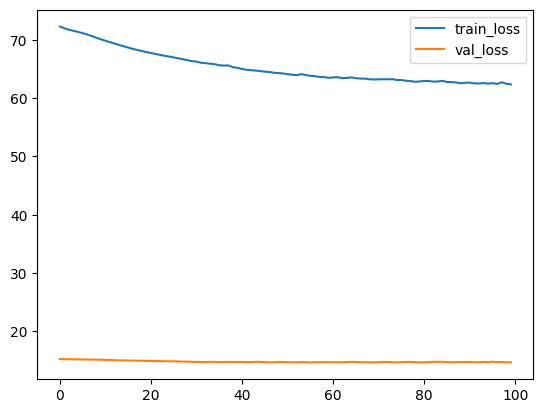

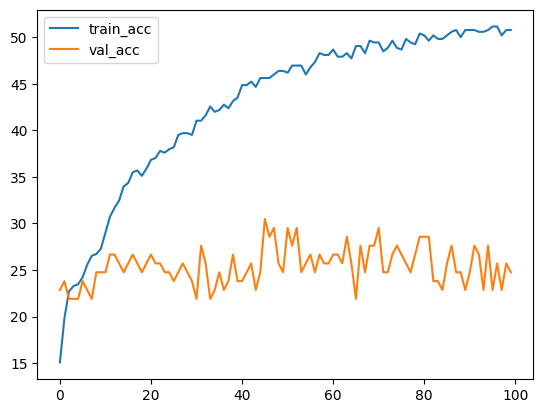

105 26

Accuracy: 24.76

Training Features Shape: (524, 49)
Training Labels Shape: (524, 9)
Testing Features Shape: (105, 49)
Testing Labels Shape: (105, 9)
Epoch 1, Trainloss: 72.42718744277954
Train Accuracy: 11.07%
Test loss: 15.31345534324646
Test Accuracy: 11.43%
Epoch 2, Trainloss: 72.21896290779114
Train Accuracy: 14.50%
Test loss: 15.308371305465698
Test Accuracy: 13.33%
Epoch 3, Trainloss: 72.03795909881592
Train Accuracy: 18.13%
Test loss: 15.303630352020264
Test Accuracy: 14.29%
Epoch 4, Trainloss: 71.84967923164368
Train Accuracy: 20.04%
Test loss: 15.299943923950195
Test Accuracy: 15.24%
Epoch 5, Trainloss: 71.68781042098999
Train Accuracy: 21.76%
Test loss: 15.29031252861023
Test Accuracy: 17.14%
Epoch 6, Trainloss: 71.5136399269104
Train Accuracy: 23.09%
Test loss: 15.288185596466064
Test Accuracy: 15.24%
Epoch 7, Trainloss: 71.33096742630005
Train Accuracy: 23.47%
Test loss: 15.284379720687866
Test Accuracy: 15.24%
Epoch 8, Trainloss: 71.12666606903076
Train Accuracy: 2

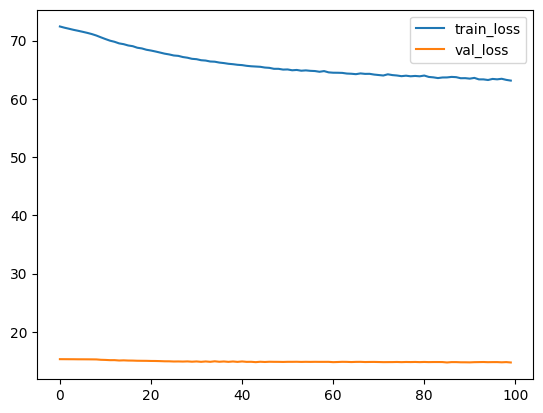

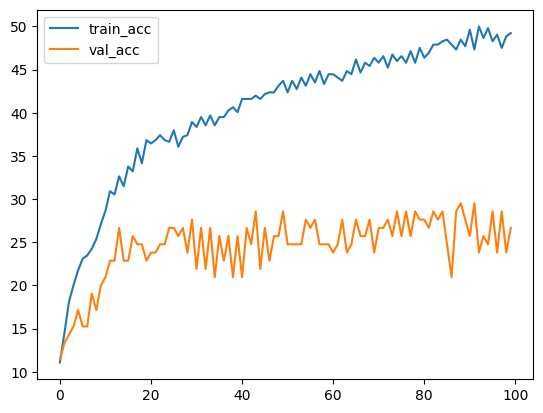

105 28

Accuracy: 26.67

Training Features Shape: (525, 49)
Training Labels Shape: (525, 9)
Testing Features Shape: (104, 49)
Testing Labels Shape: (104, 9)
Epoch 1, Trainloss: 72.66097807884216
Train Accuracy: 10.67%
Test loss: 15.363097906112671
Test Accuracy: 13.46%
Epoch 2, Trainloss: 72.43224096298218
Train Accuracy: 13.14%
Test loss: 15.337316513061523
Test Accuracy: 13.46%
Epoch 3, Trainloss: 72.25385570526123
Train Accuracy: 15.81%
Test loss: 15.311861038208008
Test Accuracy: 17.31%
Epoch 4, Trainloss: 72.08425331115723
Train Accuracy: 17.33%
Test loss: 15.285326719284058
Test Accuracy: 18.27%
Epoch 5, Trainloss: 71.87821578979492
Train Accuracy: 18.67%
Test loss: 15.256972312927246
Test Accuracy: 22.12%
Epoch 6, Trainloss: 71.6720039844513
Train Accuracy: 20.95%
Test loss: 15.217095375061035
Test Accuracy: 22.12%
Epoch 7, Trainloss: 71.40461850166321
Train Accuracy: 21.71%
Test loss: 15.165859699249268
Test Accuracy: 21.15%
Epoch 8, Trainloss: 71.14016890525818
Train Accuracy:

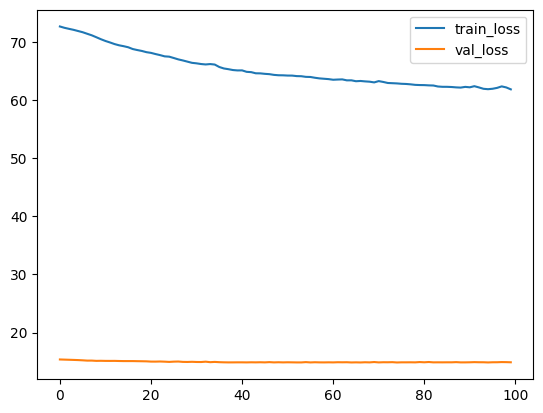

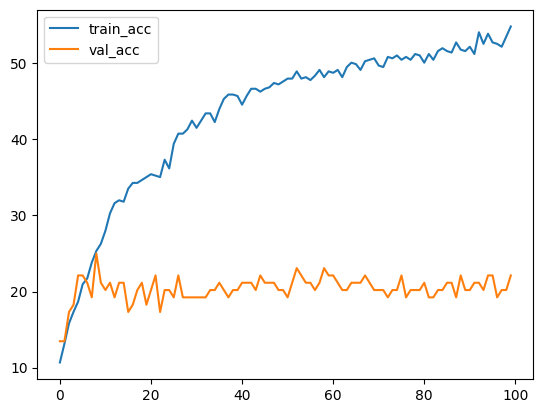

104 23

Accuracy: 22.12



In [18]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


feature_list = list(X.columns)

X = X.to_numpy()
y = y.to_numpy()
kf = KFold(n_splits=6)

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    train_features, test_features = X[train_index], X[test_index]
    train_labels, test_labels = y[train_index], y[test_index]
    
    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test_features.shape)
    print('Testing Labels Shape:', test_labels.shape)

    train_dataset = TabularDataset(train_features, train_labels)

    train_loader = DataLoader(train_dataset, batch_size=16)

    test_dataset = TabularDataset(test_features, test_labels)

    test_loader = DataLoader(test_dataset, batch_size=16)

    model = Net(input_size=train_features.shape[1], hidden_size=10, num_classes=9)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)

    trainLosses = []
    testLosses = []
    trainAcc = []
    testAcc = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model,train_loader,epoch,criterion,optimizer)
        test_loss, test_acc = test(model,test_loader,criterion)
        trainLosses.append(train_loss)
        testLosses.append(test_loss)
        trainAcc.append(train_acc)
        testAcc.append(test_acc)
    plt.plot(trainLosses,label='train_loss')
    plt.plot(testLosses,label='val_loss')
    plt.legend()
    plt.show()
    plt.plot(trainAcc,label='train_acc')
    plt.plot(testAcc,label='val_acc')
    plt.legend()
    plt.show()
    
    with torch.no_grad():
        correct = 0
        total = 0
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.argmax(dim=1)).sum().item() 
            
    print(total, correct)
    accuracy = 100 * (correct / total)
    print('\nAccuracy: {:.2f}\n'.format(accuracy))

 